In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_fb15k_237
from ampligraph.latent_features.models import TransE, ComplEx

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso

In [4]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [5]:
X = load_fb15k_237()

In [19]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions_triples(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_batch, batches_count=batches_count, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(x_neg_tf))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        print(e)
        dataset_handle.cleanup()

In [15]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [8]:
model = ComplEx(batches_count=64, seed=0, epochs=500, k=350, eta=30,
                optimizer='adam', optimizer_params={'lr':0.00005},
                regularizer='LP', regularizer_params={'lambda': 0.0001},
                loss='multiclass_nll', verbose=True)

filter_triples = np.concatenate((X['train'], X['valid'], X['test']))

model.fit(X['train'], False)

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

Average Loss:   0.206223: 100%|██████████| 500/500 [27:24<00:00,  3.29s/epoch]


In [9]:
ranks = evaluate_performance(X['test'], 
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True, 
                             verbose=False)

100%|██████████| 20438/20438 [02:22<00:00, 143.53it/s]


In [10]:
mrr_score(ranks),  hits_at_n_score(ranks, n=10), mr_score(ranks)

(0.3203637788540833, 0.4987767883354536, 182.66488893238085)

In [16]:
model.generate_corruptions_triples = types.MethodType(generate_corruptions_triples, model)
fake_negatives = model.generate_corruptions_triples(X['test'], batches_count=10, epochs=1000)

WARNING - From /home/ptabacof/AmpliGraph-Lab/ampligraph/evaluation/protocol.py:352: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.random.categorical instead.


100%|██████████| 1000/1000 [00:28<00:00, 35.55epoch/s]


In [17]:
idx_to_ent = {v: k for k, v in model.ent_to_idx.items()} 
idx_to_rel = {v: k for k, v in model.rel_to_idx.items()} 

In [24]:
results = []
                                        
for pbr in np.linspace(0.05, 0.95, 19):

    fake_idx = np.random.randint(len(fake_negatives), size=int(len(X['test'])/pbr-len(X['test'])))
    fake_test = fake_negatives[fake_idx, :]

    s = np.vectorize(idx_to_ent.get)(fake_test[:, 0])
    p = np.vectorize(idx_to_rel.get)(fake_test[:, 1])
    o = np.vectorize(idx_to_ent.get)(fake_test[:, 2])

    fake_test = np.vstack((s, p, o)).T
    X_test = np.vstack((X['test'], fake_test))
    X_test_labels = np.concatenate((np.ones(len(X['test'])), np.zeros(len(fake_idx))))
    
    scores = model.predict(X_test)

    model.calibrate(X['valid'], batches_count=10, epochs=1000, positive_base_rate=pbr)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X_test)

    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X['valid'], batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X['valid']))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=pbr)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=pbr)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))

    results.append({
        'pbr': pbr,
        'brier_score_baseline': brier_score_loss(X_test_labels, np.array([pbr]*len(X_test_labels))),
        'log_loss_baseline': log_loss(X_test_labels, np.array([pbr]*len(X_test_labels)), eps=1e-7),
        'brier_score_scores': brier_score_loss(X_test_labels, expit(scores)),
        'log_loss_scores': log_loss(X_test_labels, expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X_test_labels, probas1),
        'log_loss_probas_pos': log_loss(X_test_labels, probas1, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X_test_labels, probas4),
        'log_loss_probas_pos_iso': log_loss(X_test_labels, probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X_test_labels, probas5),
        'log_loss_probas_pos_sc': log_loss(X_test_labels, probas5, eps=1e-7),
        'ece_scores': calibration_loss(X_test_labels, expit(scores)),
        'ece_probas_pos': calibration_loss(X_test_labels, probas1),
        'ece_probas_pos_iso': calibration_loss(X_test_labels, probas4),
        'ece_probas_pos_sc': calibration_loss(X_test_labels, probas5),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks)
    })
        
    print(json.dumps(results[-1], indent=2))

Calibration Loss:   0.830982: 100%|██████████| 1000/1000 [00:40<00:00, 22.62epoch/s]


pos [-0.44122803, 5.0400944]


100%|██████████| 1000/1000 [00:30<00:00, 33.20epoch/s]


pos sc -0.450853233926018 5.448441701088486
{
  "pbr": 0.05,
  "brier_score_baseline": 0.04749999999999995,
  "log_loss_baseline": 0.19851524334587223,
  "brier_score_scores": 0.26980923178549016,
  "log_loss_scores": 1.4254506676883343,
  "brier_score_probas_pos": 0.03022059993355192,
  "log_loss_probas_pos": 0.09573632062397083,
  "brier_score_probas_pos_iso": 0.02904455848861283,
  "log_loss_probas_pos_iso": 0.08998615245941406,
  "brier_score_probas_pos_sc": 0.02996057168893332,
  "log_loss_probas_pos_sc": 0.09415125535095266,
  "ece_scores": 0.41351468573112127,
  "ece_probas_pos": 0.010318255216854403,
  "ece_probas_pos_iso": 0.0006545040186330029,
  "ece_probas_pos_sc": 0.008704743413331146,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.588032: 100%|██████████| 1000/1000 [00:39<00:00, 25.36epoch/s]


pos [-0.49303725, 4.808776]


100%|██████████| 1000/1000 [00:29<00:00, 33.42epoch/s]


pos sc -0.44800720876236055 4.699874586718216
{
  "pbr": 0.1,
  "brier_score_baseline": 0.08999999999999986,
  "log_loss_baseline": 0.3250829733914479,
  "brier_score_scores": 0.25379738360101556,
  "log_loss_scores": 1.334598660038867,
  "brier_score_probas_pos": 0.043262066647011634,
  "log_loss_probas_pos": 0.13631289918028322,
  "brier_score_probas_pos_iso": 0.041901695720859784,
  "log_loss_probas_pos_iso": 0.12830096648038136,
  "brier_score_probas_pos_sc": 0.04312894122049539,
  "log_loss_probas_pos_sc": 0.13527496434678835,
  "ece_scores": 0.3899569472497615,
  "ece_probas_pos": 0.013421767335871752,
  "ece_probas_pos_iso": 0.001200075820617559,
  "ece_probas_pos_sc": 0.01602823671431844,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.467873: 100%|██████████| 1000/1000 [00:40<00:00, 23.47epoch/s]


pos [-0.5196964, 4.589352]


100%|██████████| 1000/1000 [00:29<00:00, 34.19epoch/s]


pos sc -0.43583415651849966 3.8104580467727147
{
  "pbr": 0.15,
  "brier_score_baseline": 0.12750025687507796,
  "log_loss_baseline": 0.4227097243428217,
  "brier_score_scores": 0.24217811888243646,
  "log_loss_scores": 1.284183769625678,
  "brier_score_probas_pos": 0.05183296479210487,
  "log_loss_probas_pos": 0.1663968349243564,
  "brier_score_probas_pos_iso": 0.0502835157618446,
  "log_loss_probas_pos_iso": 0.15569822322574853,
  "brier_score_probas_pos_sc": 0.05131279315458267,
  "log_loss_probas_pos_sc": 0.16800470746315727,
  "ece_scores": 0.36999146187807563,
  "ece_probas_pos": 0.016368070203471436,
  "ece_probas_pos_iso": 0.0020625349689011186,
  "ece_probas_pos_sc": 0.020485101126379787,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.390925: 100%|██████████| 1000/1000 [00:39<00:00, 25.47epoch/s]


pos [-0.5364693, 4.3821664]


100%|██████████| 1000/1000 [00:29<00:00, 33.87epoch/s]


pos sc -0.44292882675460604 4.242331740162054
{
  "pbr": 0.2,
  "brier_score_baseline": 0.16000000000000011,
  "log_loss_baseline": 0.5004024235381878,
  "brier_score_scores": 0.22706986458678013,
  "log_loss_scores": 1.1948120494444805,
  "brier_score_probas_pos": 0.05561868794343745,
  "log_loss_probas_pos": 0.18281052882118026,
  "brier_score_probas_pos_iso": 0.054243678399247576,
  "log_loss_probas_pos_iso": 0.17140446391213182,
  "brier_score_probas_pos_sc": 0.05904878342041919,
  "log_loss_probas_pos_sc": 0.1881691734261763,
  "ece_scores": 0.347013538277351,
  "ece_probas_pos": 0.018049085680338868,
  "ece_probas_pos_iso": 0.0020299018693885995,
  "ece_probas_pos_sc": 0.03289293406845991,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.335390: 100%|██████████| 1000/1000 [00:40<00:00, 24.72epoch/s]


pos [-0.5484132, 4.1875496]


100%|██████████| 1000/1000 [00:31<00:00, 31.88epoch/s]


pos sc -0.4337406897319396 3.5271707614686103
{
  "pbr": 0.25,
  "brier_score_baseline": 0.1875,
  "log_loss_baseline": 0.5623351446188083,
  "brier_score_scores": 0.2120990000773988,
  "log_loss_scores": 1.1196625558709161,
  "brier_score_probas_pos": 0.058342808392123476,
  "log_loss_probas_pos": 0.19624549810914835,
  "brier_score_probas_pos_iso": 0.05685647734689661,
  "log_loss_probas_pos_iso": 0.18320214563777243,
  "brier_score_probas_pos_sc": 0.05876741835595218,
  "log_loss_probas_pos_sc": 0.19761974797141282,
  "ece_scores": 0.3243011260338289,
  "ece_probas_pos": 0.020467531028961827,
  "ece_probas_pos_iso": 0.0034220813693531106,
  "ece_probas_pos_sc": 0.031594872038841086,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.292378: 100%|██████████| 1000/1000 [00:39<00:00, 26.49epoch/s]


pos [-0.5578609, 4.005075]


100%|██████████| 1000/1000 [00:30<00:00, 32.45epoch/s]


pos sc -0.4303138850915756 3.103476418955717
{
  "pbr": 0.3,
  "brier_score_baseline": 0.2100011742946893,
  "log_loss_baseline": 0.6108667894983377,
  "brier_score_scores": 0.19821798526803341,
  "log_loss_scores": 1.0383687311408418,
  "brier_score_probas_pos": 0.059089893584680926,
  "log_loss_probas_pos": 0.20259537639379138,
  "brier_score_probas_pos_iso": 0.05760362562217982,
  "log_loss_probas_pos_iso": 0.1894706133214513,
  "brier_score_probas_pos_sc": 0.059018959241297575,
  "log_loss_probas_pos_sc": 0.20631922199498778,
  "ece_scores": 0.3024551713683274,
  "ece_probas_pos": 0.02158490033059149,
  "ece_probas_pos_iso": 0.0033218000937571173,
  "ece_probas_pos_sc": 0.03358263921913,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.257447: 100%|██████████| 1000/1000 [00:40<00:00, 24.75epoch/s]


pos [-0.5660413, 3.8333955]


100%|██████████| 1000/1000 [00:28<00:00, 34.95epoch/s]


pos sc -0.4249351122070513 2.6027989143605748
{
  "pbr": 0.35,
  "brier_score_baseline": 0.2275005137514129,
  "log_loss_baseline": 0.6474476991421921,
  "brier_score_scores": 0.18779365228188494,
  "log_loss_scores": 1.00681186424528,
  "brier_score_probas_pos": 0.06264089844180341,
  "log_loss_probas_pos": 0.2161702127170621,
  "brier_score_probas_pos_iso": 0.060948936065319856,
  "log_loss_probas_pos_iso": 0.20205349006725867,
  "brier_score_probas_pos_sc": 0.062700399030859,
  "log_loss_probas_pos_sc": 0.22596549762365803,
  "ece_scores": 0.2836055745816204,
  "ece_probas_pos": 0.025499032066918243,
  "ece_probas_pos_iso": 0.005165833751140523,
  "ece_probas_pos_sc": 0.0347326766005766,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.228080: 100%|██████████| 1000/1000 [00:40<00:00, 24.47epoch/s]


pos [-0.5736308, 3.6703708]


100%|██████████| 1000/1000 [00:31<00:00, 31.58epoch/s]


pos sc -0.4199623323413796 2.266455873130448
{
  "pbr": 0.39999999999999997,
  "brier_score_baseline": 0.24000000000000002,
  "log_loss_baseline": 0.6730116670092564,
  "brier_score_scores": 0.17082503312823508,
  "log_loss_scores": 0.9111823747386303,
  "brier_score_probas_pos": 0.060788203784938676,
  "log_loss_probas_pos": 0.21641526675875367,
  "brier_score_probas_pos_iso": 0.05895836207944596,
  "log_loss_probas_pos_iso": 0.20073318715618454,
  "brier_score_probas_pos_sc": 0.061829698248956226,
  "log_loss_probas_pos_sc": 0.23226460749996394,
  "ece_scores": 0.25887204230047506,
  "ece_probas_pos": 0.027719883704584457,
  "ece_probas_pos_iso": 0.003910326600513463,
  "ece_probas_pos_sc": 0.042930021830265806,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.202717: 100%|██████████| 1000/1000 [00:38<00:00, 25.43epoch/s]


pos [-0.5810122, 3.513366]


100%|██████████| 1000/1000 [00:30<00:00, 32.93epoch/s]


pos sc -0.416994210182014 2.0260310635213106
{
  "pbr": 0.44999999999999996,
  "brier_score_baseline": 0.24750077063654588,
  "log_loss_baseline": 0.6881403601553046,
  "brier_score_scores": 0.1564589024743738,
  "log_loss_scores": 0.8266344608473133,
  "brier_score_probas_pos": 0.05891980763803334,
  "log_loss_probas_pos": 0.21320748200353237,
  "brier_score_probas_pos_iso": 0.056783481757926926,
  "log_loss_probas_pos_iso": 0.19729411923601217,
  "brier_score_probas_pos_sc": 0.06076750186446273,
  "log_loss_probas_pos_sc": 0.23341027937493367,
  "ece_scores": 0.23687160928789489,
  "ece_probas_pos": 0.028261867007226087,
  "ece_probas_pos_iso": 0.003960333785657498,
  "ece_probas_pos_sc": 0.04697122187452604,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.180329: 100%|██████████| 1000/1000 [00:42<00:00, 23.58epoch/s]


pos [-0.5884199, 3.3595138]


100%|██████████| 1000/1000 [00:35<00:00, 28.87epoch/s]


pos sc -0.4123244764315961 2.122247964406506
{
  "pbr": 0.49999999999999994,
  "brier_score_baseline": 0.25,
  "log_loss_baseline": 0.6931471805599454,
  "brier_score_scores": 0.1426850921701486,
  "log_loss_scores": 0.7554543973614781,
  "brier_score_probas_pos": 0.057302535297342874,
  "log_loss_probas_pos": 0.21116404653382684,
  "brier_score_probas_pos_iso": 0.054967349335739935,
  "log_loss_probas_pos_iso": 0.19488918126956623,
  "brier_score_probas_pos_sc": 0.058336825293231885,
  "log_loss_probas_pos_sc": 0.2235036814143973,
  "ece_scores": 0.21489111510890024,
  "ece_probas_pos": 0.028764399031928286,
  "ece_probas_pos_iso": 0.003695730838873606,
  "ece_probas_pos_sc": 0.04102365919891314,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.160191: 100%|██████████| 1000/1000 [00:42<00:00, 23.74epoch/s]


pos [-0.5960073, 3.2056608]


100%|██████████| 1000/1000 [00:35<00:00, 28.04epoch/s]


pos sc -0.41318873775913356 2.2876358726657706
{
  "pbr": 0.5499999999999999,
  "brier_score_baseline": 0.24750000000000005,
  "log_loss_baseline": 0.6881388137135885,
  "brier_score_scores": 0.12890994096948222,
  "log_loss_scores": 0.6795005751356494,
  "brier_score_probas_pos": 0.054568615564771376,
  "log_loss_probas_pos": 0.20529163674947518,
  "brier_score_probas_pos_iso": 0.05210869395508585,
  "log_loss_probas_pos_iso": 0.18884781609935242,
  "brier_score_probas_pos_sc": 0.05675789638750858,
  "log_loss_probas_pos_sc": 0.21646515781841863,
  "ece_scores": 0.1936004482634743,
  "ece_probas_pos": 0.029851878754417683,
  "ece_probas_pos_iso": 0.0031003763829702317,
  "ece_probas_pos_sc": 0.052452325559824035,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.141772: 100%|██████████| 1000/1000 [00:42<00:00, 22.85epoch/s]


pos [-0.60396, 3.0488243]


100%|██████████| 1000/1000 [00:34<00:00, 28.74epoch/s]


pos sc -0.41476485687476017 2.244156337091305
{
  "pbr": 0.6,
  "brier_score_baseline": 0.23999882570531084,
  "log_loss_baseline": 0.6730092863316406,
  "brier_score_scores": 0.11443739430805361,
  "log_loss_scores": 0.6067865080111122,
  "brier_score_probas_pos": 0.05197397626176126,
  "log_loss_probas_pos": 0.19859429543973908,
  "brier_score_probas_pos_iso": 0.049361849978720264,
  "log_loss_probas_pos_iso": 0.1823144934576228,
  "brier_score_probas_pos_sc": 0.05506736062470701,
  "log_loss_probas_pos_sc": 0.2114385522844882,
  "ece_scores": 0.17068563085635044,
  "ece_probas_pos": 0.029556631660467025,
  "ece_probas_pos_iso": 0.0034554073451883082,
  "ece_probas_pos_sc": 0.05672226680593059,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.124660: 100%|██████████| 1000/1000 [00:42<00:00, 22.91epoch/s]


pos [-0.6124753, 2.8854053]


100%|██████████| 1000/1000 [00:32<00:00, 30.32epoch/s]


pos sc -0.40981175704631245 2.082344164399395
{
  "pbr": 0.65,
  "brier_score_baseline": 0.2274995229462838,
  "log_loss_baseline": 0.6474456546514498,
  "brier_score_scores": 0.10221794679605957,
  "log_loss_scores": 0.542251328725139,
  "brier_score_probas_pos": 0.048988604338296445,
  "log_loss_probas_pos": 0.19119829827527524,
  "brier_score_probas_pos_iso": 0.04642936410510346,
  "log_loss_probas_pos_iso": 0.1747381649296076,
  "brier_score_probas_pos_sc": 0.052675522843110244,
  "log_loss_probas_pos_sc": 0.20607230899501092,
  "ece_scores": 0.1510108001692485,
  "ece_probas_pos": 0.02823633674946966,
  "ece_probas_pos_iso": 0.0038587773343624026,
  "ece_probas_pos_sc": 0.06037005883914722,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
Calibration Loss:   0.108513: 100%|██████████| 1000/1000 [00:42<00:00, 23.55epoch/s]


pos [-0.6218169, 2.7108257]


100%|██████████| 1000/1000 [00:35<00:00, 29.66epoch/s]


pos sc -0.41674778119127287 2.0319100219446704
{
  "pbr": 0.7,
  "brier_score_baseline": 0.20999862999623256,
  "log_loss_baseline": 0.6108614000517412,
  "brier_score_scores": 0.08570926117322997,
  "log_loss_scores": 0.44309388279265255,
  "brier_score_probas_pos": 0.04280347827409644,
  "log_loss_probas_pos": 0.17055661212380274,
  "brier_score_probas_pos_iso": 0.04005151579918727,
  "log_loss_probas_pos_iso": 0.15598620995792975,
  "brier_score_probas_pos_sc": 0.04752811598752329,
  "log_loss_probas_pos_sc": 0.1896952112728663,
  "ece_scores": 0.12701183138397673,
  "ece_probas_pos": 0.027883710553189906,
  "ece_probas_pos_iso": 0.002030247268691671,
  "ece_probas_pos_sc": 0.06353839626560329,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.093024: 100%|██████████| 1000/1000 [00:42<00:00, 23.29epoch/s]


pos [-0.632363, 2.5185409]


100%|██████████| 1000/1000 [00:33<00:00, 30.30epoch/s]


pos sc -0.40810995722274035 1.1386188516378033
{
  "pbr": 0.75,
  "brier_score_baseline": 0.1874908256880734,
  "log_loss_baseline": 0.562314986595163,
  "brier_score_scores": 0.07123334826448943,
  "log_loss_scores": 0.3766241019840096,
  "brier_score_probas_pos": 0.038937310700674396,
  "log_loss_probas_pos": 0.16026376701823458,
  "brier_score_probas_pos_iso": 0.03588276484413837,
  "log_loss_probas_pos_iso": 0.14439416937191413,
  "brier_score_probas_pos_sc": 0.04352816083486665,
  "log_loss_probas_pos_sc": 0.17889489261354855,
  "ece_scores": 0.1041231599860235,
  "ece_probas_pos": 0.025407916707730037,
  "ece_probas_pos_iso": 0.0029120667091843376,
  "ece_probas_pos_sc": 0.04917408856333127,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
Calibration Loss:   0.077884: 100%|██████████| 1000/1000 [00:41<00:00, 24.15epoch/s]


pos [-0.6447056, 2.2980225]


100%|██████████| 1000/1000 [00:34<00:00, 29.27epoch/s]


pos sc -0.4144261500503252 1.8980809225094464
{
  "pbr": 0.7999999999999999,
  "brier_score_baseline": 0.15999060555055386,
  "log_loss_baseline": 0.5003807177510329,
  "brier_score_scores": 0.058683450354320064,
  "log_loss_scores": 0.3109757553306465,
  "brier_score_probas_pos": 0.03440950533556503,
  "log_loss_probas_pos": 0.14498098638757806,
  "brier_score_probas_pos_iso": 0.03173961961119595,
  "log_loss_probas_pos_iso": 0.13052374559785376,
  "brier_score_probas_pos_sc": 0.042045615439749454,
  "log_loss_probas_pos_sc": 0.17219221093483683,
  "ece_scores": 0.08353118338024756,
  "ece_probas_pos": 0.023195337576329925,
  "ece_probas_pos_iso": 0.003201844640555683,
  "ece_probas_pos_sc": 0.06928019973071929,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.062722: 100%|██████████| 1000/1000 [00:41<00:00, 26.45epoch/s]


pos [-0.65985125, 2.029704]


100%|██████████| 1000/1000 [00:30<00:00, 32.31epoch/s]


pos sc -0.40621707789178174 1.4792098291213858
{
  "pbr": 0.85,
  "brier_score_baseline": 0.12748253202462154,
  "log_loss_baseline": 0.4226658021366665,
  "brier_score_scores": 0.04376995376085403,
  "log_loss_scores": 0.23283796094606704,
  "brier_score_probas_pos": 0.028357334988879893,
  "log_loss_probas_pos": 0.12243839545382189,
  "brier_score_probas_pos_iso": 0.025650700150728005,
  "log_loss_probas_pos_iso": 0.10918277891280431,
  "brier_score_probas_pos_sc": 0.034035069995010034,
  "log_loss_probas_pos_sc": 0.14574186293503685,
  "ece_scores": 0.06059665081802846,
  "ece_probas_pos": 0.020412215018823714,
  "ece_probas_pos_iso": 0.003618408557025277,
  "ece_probas_pos_sc": 0.06025897996035086,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.046978: 100%|██████████| 1000/1000 [00:40<00:00, 24.14epoch/s]


pos [-0.6796722, 1.6689684]


100%|██████████| 1000/1000 [00:32<00:00, 30.29epoch/s]


pos sc -0.4004568842503645 1.0488643506096726
{
  "pbr": 0.9,
  "brier_score_baseline": 0.08997181610005286,
  "log_loss_baseline": 0.325005565444387,
  "brier_score_scores": 0.029888923600977956,
  "log_loss_scores": 0.1549024823497006,
  "brier_score_probas_pos": 0.02114033516996933,
  "log_loss_probas_pos": 0.09409248252906899,
  "brier_score_probas_pos_iso": 0.019102052019867574,
  "log_loss_probas_pos_iso": 0.08333943096021468,
  "brier_score_probas_pos_sc": 0.025770285221293786,
  "log_loss_probas_pos_sc": 0.11536179369797707,
  "ece_scores": 0.039315355775304574,
  "ece_probas_pos": 0.01455790294776898,
  "ece_probas_pos_iso": 0.0019909200474455533,
  "ece_probas_pos_sc": 0.050426725993103355,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


Calibration Loss:   0.029441: 100%|██████████| 1000/1000 [00:41<00:00, 25.09epoch/s]


pos [-0.70737255, 1.0662148]


100%|██████████| 1000/1000 [00:33<00:00, 29.74epoch/s]


pos sc -0.39859661833693294 0.36710001090671784
{
  "pbr": 0.95,
  "brier_score_baseline": 0.04747280713986892,
  "log_loss_baseline": 0.19842627921551143,
  "brier_score_scores": 0.015817127376793094,
  "log_loss_scores": 0.08848061567353917,
  "brier_score_probas_pos": 0.014024524014923007,
  "log_loss_probas_pos": 0.06570007228474867,
  "brier_score_probas_pos_iso": 0.012490009460111893,
  "log_loss_probas_pos_iso": 0.05743645585721034,
  "brier_score_probas_pos_sc": 0.017070839127696975,
  "log_loss_probas_pos_sc": 0.07747046639392467,
  "ece_scores": 0.01770403638619935,
  "ece_probas_pos": 0.011711201640965964,
  "ece_probas_pos_iso": 0.0021733243809249126,
  "ece_probas_pos_sc": 0.03268925297681467,
  "metrics_mrr": 0.3203637788540833,
  "metrics_hits@10": 0.4987767883354536,
  "metrics_mr": 182.66488893238085
}


In [25]:
import pandas as pd

In [26]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

In [27]:
df = pd.DataFrame(results).set_index(['pbr'])
df.index = [np.round(i, 2) for i in df.index]
df.to_csv("main_results_fb15k_237.csv", index=False)

In [28]:
bs = df[(c for c in df.columns if c.startswith('brier'))]
bs.columns = [c[len("brier_score_"):] for c in bs.columns]
bs.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.0475,0.0302206,0.0290446,0.0299606,0.269809
0.1,0.09,0.0432621,0.0419017,0.0431289,0.253797
0.15,0.1275,0.051833,0.0502835,0.0513128,0.242178
0.2,0.16,0.0556187,0.0542437,0.0590488,0.22707
0.25,0.1875,0.0583428,0.0568565,0.0587674,0.212099
0.3,0.210001,0.0590899,0.0576036,0.059019,0.198218
0.35,0.227501,0.0626409,0.0609489,0.0627004,0.187794
0.4,0.24,0.0607882,0.0589584,0.0618297,0.170825
0.45,0.247501,0.0589198,0.0567835,0.0607675,0.156459
0.5,0.25,0.0573025,0.0549673,0.0583368,0.142685


Text(0.5, 1.0, 'FB15K-237: Synthetic calibration')

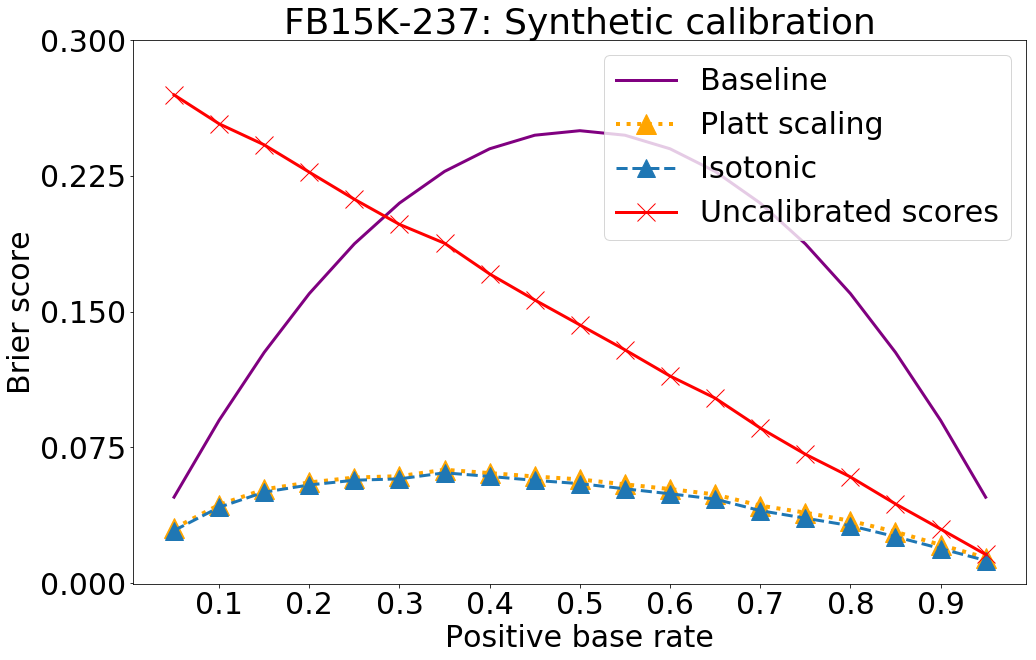

In [34]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(bs.index, bs.baseline, "-", lw=3, label="Baseline",
         fillstyle='full', color='purple', markersize=18)
plt.plot(bs.index, bs.probas_pos, "^:",lw=4, label="Platt scaling",  
         fillstyle='full', color='orange', markersize=20)
plt.plot(bs.index, bs.probas_pos_iso, "^--",  lw=3, label="Isotonic", 
         fillstyle='full', color='tab:blue', markersize=18)
plt.plot(bs.index, bs.scores, "x-",lw=3,  
         fillstyle='full', color='r', markersize=18,
         label="Uncalibrated scores")

plt.xlabel("Positive base rate")
plt.ylabel("Brier score")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.yticks(np.linspace(0, 0.3, 5))
plt.title("FB15K-237: Synthetic calibration")

In [30]:
ll = df[(c for c in df.columns if c.startswith('log_loss'))]
ll.columns = [c[len("log_loss_"):] for c in ll.columns]
ll.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.198515,0.0957363,0.0899862,0.0941513,1.42545
0.1,0.325083,0.136313,0.128301,0.135275,1.3346
0.15,0.42271,0.166397,0.155698,0.168005,1.28418
0.2,0.500402,0.182811,0.171404,0.188169,1.19481
0.25,0.562335,0.196245,0.183202,0.19762,1.11966
0.3,0.610867,0.202595,0.189471,0.206319,1.03837
0.35,0.647448,0.21617,0.202053,0.225965,1.00681
0.4,0.673012,0.216415,0.200733,0.232265,0.911182
0.45,0.68814,0.213207,0.197294,0.23341,0.826634
0.5,0.693147,0.211164,0.194889,0.223504,0.755454


Text(0.5, 1.0, 'FB15K-237: Synthetic calibration')

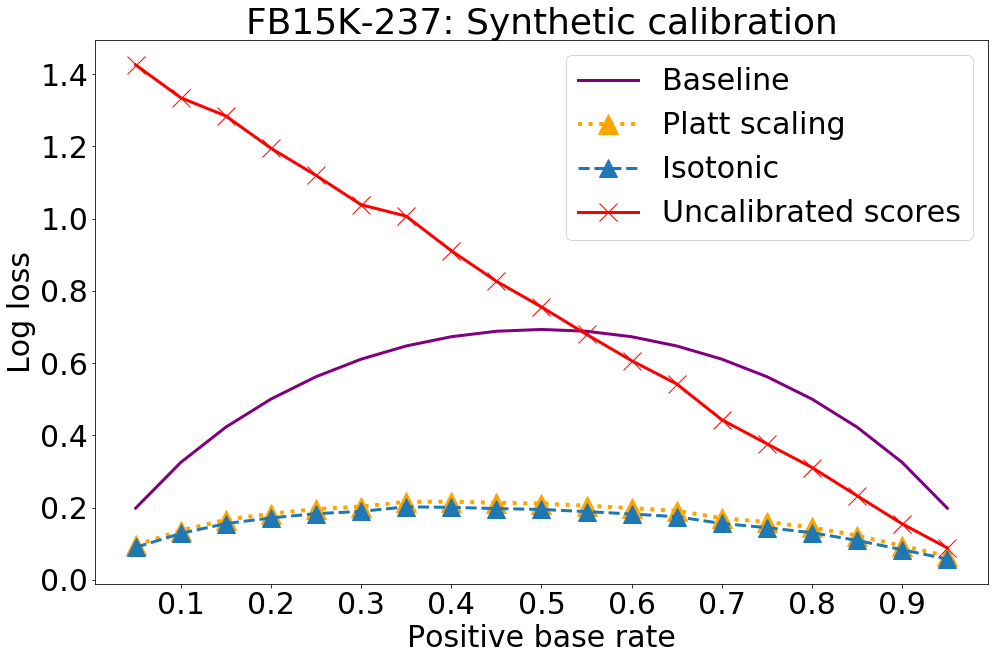

In [33]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(ll.index, ll.baseline, "-", lw=3, label="Baseline",
         fillstyle='full', color='purple', markersize=18)
plt.plot(ll.index, ll.probas_pos, "^:",lw=4, label="Platt scaling",  
         fillstyle='full', color='orange', markersize=20)
plt.plot(ll.index, ll.probas_pos_iso, "^--",  lw=3, label="Isotonic", 
         fillstyle='full', color='tab:blue', markersize=18)
plt.plot(ll.index, ll.scores, "x-",lw=3,  
         fillstyle='full', color='r', markersize=18,
         label="Uncalibrated scores")

plt.xlabel("Positive base rate")
plt.ylabel("Log loss")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("FB15K-237: Synthetic calibration")